# Importing and setting up Dataset

Import Training data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Unzips training data into colab

In [ ]:
!unzip /content/gdrive/MyDrive/Dissertation/CNN\ Training/Greyscale_Rendering.zip

Specifies local root folder

In [ ]:
import os

SOURCE = "Greyscale_Rendering"
CSV_SOURCE = os.path.join(SOURCE, "train.csv")
TEST_CSV_SOURCE = os.path.join(SOURCE, "test.csv")
IMAGE_SOURCE = os.path.join(SOURCE, "images")
IMAGE_SIZE = 135
NUM_PATCHES = 64

String formatting function

In [ ]:
# Used later to print out time taken during training
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Import dataset as dataframe

In [ ]:
import pandas as pd

df = pd.read_csv(CSV_SOURCE)
dfTestData = pd.read_csv(TEST_CSV_SOURCE)

df.sort_values("label")

,id,label,filename
15119,15119,-20000.000,mars_image_c-236~15.jpg
1088,1088,-20000.000,mars_image_c-17~0.jpg
12272,12272,-20000.000,mars_image_c-191~48.jpg
7428,7428,-20000.000,mars_image_c-116~4.jpg
12280,12280,-20000.000,mars_image_c-191~56.jpg
...,...,...,...
5769,5769,825.951,mars_image_c-90~9.jpg
5793,5793,826.486,mars_image_c-90~33.jpg
5474,5474,828.101,mars_image_c-85~34.jpg
14387,14387,894.612,mars_image_c-224~51.jpg


# Preprocessing

Training dataset preprocessing

In [ ]:
# Dropping rows with erroneous labels and ALL corner patches
import math

originalSize = len(df)
print(originalSize)

# Patches with no vertices
df = df.drop(df[df["label"] == -20000.000].index)
print(len(df))
# Patches with 1 vertex
df = df.drop(df[df["label"] == 0.0].index)
print(len(df))
# Patches with negative value labels
df = df.drop(df[df["label"] < 0.0].index)

## Drop Corner patches
# Top-Left
df = df.drop(df[df["id"] % NUM_PATCHES == 0].index) # If patchNum = 0
print(len(df))
# Top-Right
df = df.drop(df[(df["id"] - (math.sqrt(NUM_PATCHES) - 1)) % NUM_PATCHES == 0].index) # If patchNum = 7
print(len(df))
# Bottom-Left
df = df.drop(df[(df["id"] + math.sqrt(NUM_PATCHES)) % NUM_PATCHES == 0].index) # If patchNum = 56
print(len(df))
# Bottom-Right
df = df.drop(df[(df["id"] + 1) % NUM_PATCHES == 0].index) # If patchNum == 63
print(len(df))

numDropped = originalSize - len(df)

print(f"Dropped {numDropped} samples")

dfExample = df.copy()

df.sort_values("label")

25024
24840
24838
24470
24091
23718
23343
Dropped 1681 samples


,id,label,filename
14425,14425,2.180,mars_image_c-225~25.jpg
7896,7896,2.330,mars_image_c-123~24.jpg
21625,21625,3.026,mars_image_c-337~57.jpg
17277,17277,4.252,mars_image_c-269~61.jpg
22748,22748,5.107,mars_image_c-355~28.jpg
...,...,...,...
5769,5769,825.951,mars_image_c-90~9.jpg
5793,5793,826.486,mars_image_c-90~33.jpg
5474,5474,828.101,mars_image_c-85~34.jpg
14387,14387,894.612,mars_image_c-224~51.jpg


Testing dataset preprocessing

In [ ]:
## Dropping rows with erroneous labels

originalSize = len(dfTestData)
print(originalSize)

# Patches with no vertices
dfTestData = dfTestData.drop(dfTestData[dfTestData["label"] == -20000.000].index)
print(len(dfTestData))
# Patches with 1 vertex
dfTestData = dfTestData.drop(dfTestData[dfTestData["label"] == 0.0].index)
print(len(dfTestData))
# Patches with negative value labels
dfTestData = dfTestData.drop(dfTestData[dfTestData["label"] < 0.0].index)

numDropped = originalSize - len(dfTestData)

print(f"Dropped {numDropped} samples")

dfTestData.sort_values('label')

4416
4375
4375
Dropped 42 samples


,id,label,filename
1212,1212,3.370,mars_image_c-409~60.jpg
3334,3334,3.739,mars_image_c-443~6.jpg
1891,1891,3.823,mars_image_c-420~35.jpg
2240,2240,6.265,mars_image_c-426~0.jpg
1899,1899,7.350,mars_image_c-420~43.jpg
...,...,...,...
2198,2198,488.333,mars_image_c-425~22.jpg
2206,2206,498.302,mars_image_c-425~30.jpg
2077,2077,509.088,mars_image_c-423~29.jpg
2069,2069,538.281,mars_image_c-423~21.jpg


Show distribution in a box plot

<Axes: title={'center': 'Distribution of pre-processed label values in native (unnormalised) form'}>

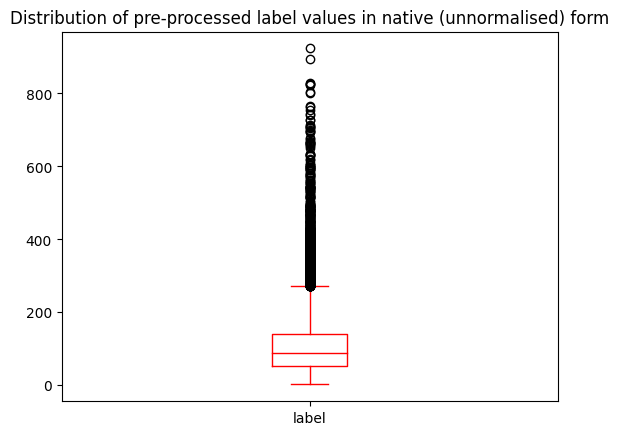

In [ ]:
from matplotlib import pyplot as plt

df['label'].plot(kind='box',
                 title='Distribution of pre-processed label values in native (unnormalised) form',
                 color='red')

Distribution of unnormalised label values

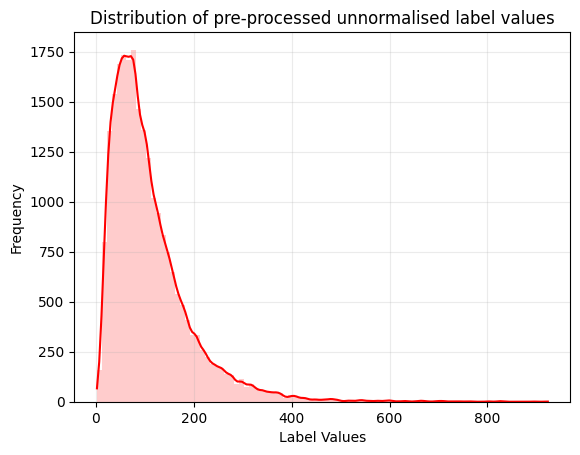

In [ ]:
import seaborn as sns

sns.histplot(data=df,
             x='label',
             binwidth=10,
             linewidth=0,
             color='red',
             alpha=0.2,
             kde=True,
             kde_kws={'bw_adjust': 0.5})

plt.title('Distribution of pre-processed unnormalised label values')
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.25)
plt.show()

# Normalising using Box-Cox

Normalising with a Box-Cox transformation to create a normal distribution

In [ ]:
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

dfNorm = df.copy()
labelsArr = dfNorm['label']

transformedLabels, lambda_ = boxcox(labelsArr)

scaler = MinMaxScaler()

labelsScaled = scaler.fit_transform(transformedLabels.reshape(-1,1))

dfNorm['label'] = labelsScaled.flatten()

dfNorm.sort_values('label')

,id,label,filename
14425,14425,0.000000,mars_image_c-225~25.jpg
7896,7896,0.007494,mars_image_c-123~24.jpg
21625,21625,0.037518,mars_image_c-337~57.jpg
17277,17277,0.078041,mars_image_c-269~61.jpg
22748,22748,0.100569,mars_image_c-355~28.jpg
...,...,...,...
5769,5769,0.974170,mars_image_c-90~9.jpg
5793,5793,0.974319,mars_image_c-90~33.jpg
5474,5474,0.974768,mars_image_c-85~34.jpg
14387,14387,0.992624,mars_image_c-224~51.jpg


Save lambda to a text file for future inverse transformations

In [ ]:
txtPath = '/content/gdrive/MyDrive/Dissertation/CNN Training/Model_results/final_lambda.txt'

file = open(txtPath, 'w')

file.write(str(lambda_))

file.close()

Save scaler object to a .pkl file for future inverse transformations

In [ ]:
import pickle

scalerPath = '/content/gdrive/MyDrive/Dissertation/CNN Training/Model_results/final_scaler.pkl'

# Save the scaler object to a file
with open(scalerPath, 'wb') as scalerFile:
    pickle.dump(scaler, scalerFile)

Distribution of normalised label values

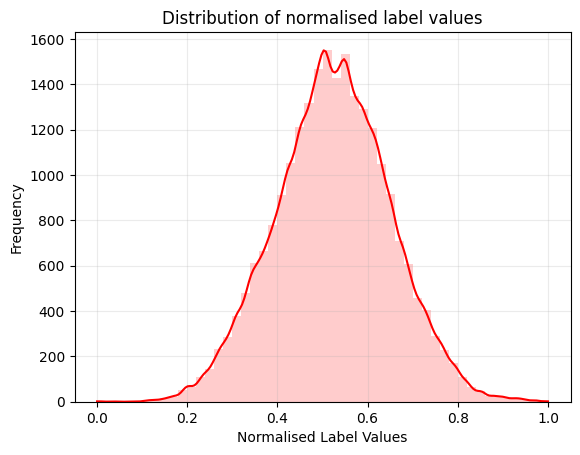

In [ ]:
sns.histplot(data=dfNorm, x='label', binwidth=0.02, linewidth=0, color='red', alpha=0.2, kde=True, kde_kws={'bw_adjust': 0.5})

plt.title('Distribution of normalised label values')
plt.xlabel('Normalised Label Values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.25)
plt.show()

# Model

Split train/validation data

In [ ]:
TRAIN_PCT = 0.82352941176 # Works out at 70/15/15 training/testing/validation
TRAIN_CUT = int(len(df) * TRAIN_PCT)

dfTrain = dfNorm[0:TRAIN_CUT]
dfValidation = dfNorm[TRAIN_CUT:]

print(f"Training size: {len(dfTrain)}")
print(f"Validation size: {len(dfValidation)}")

Training size: 19223
Validation size: 4120


Installs keras-preprocessing

In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


Preprocesses data so it can be fed into a model for training and testing

In [ ]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator

BATCH_SIZE = 256

# Normalises rgb values to 0-1
trainingDatagen = ImageDataGenerator(
  rescale=1/255
)

trainGen = trainingDatagen.flow_from_dataframe(
  dataframe=dfTrain,
  directory=IMAGE_SOURCE,
  x_col="filename",
  y_col="label",
  batch_size=BATCH_SIZE,
  class_mode='other',
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  color_mode='grayscale'
)

valDatagen = ImageDataGenerator(
  rescale=1./255
)

valGen = valDatagen.flow_from_dataframe(
  dataframe=dfValidation,
  directory=IMAGE_SOURCE,
  x_col="filename",
  y_col="label",
  class_mode='other',
  batch_size=BATCH_SIZE,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  color_mode='grayscale'
)

Found 19223 validated image filenames.
Found 4120 validated image filenames.


CNN Model Setup

In [ ]:
from tensorflow import keras
import time

colourDepth = 1

## CNN model

model = tf.keras.models.Sequential([
  # Convolution layer
  tf.keras.layers.Conv2D(32, (4,4), activation='relu',
      input_shape=(IMAGE_SIZE, IMAGE_SIZE, colourDepth),
      strides=(1,1)),
  # Max pooling layer
  tf.keras.layers.MaxPooling2D(2, 2),

  # Convolution layer
  tf.keras.layers.Conv2D(64, (4,4), activation='relu',
      input_shape=(IMAGE_SIZE, IMAGE_SIZE, colourDepth),
      strides=(1,1)),
  # Max pooling layer
  tf.keras.layers.MaxPooling2D(2,2),

  # Convolution layer
  tf.keras.layers.Conv2D(128, (4,4), activation='relu',
      input_shape=(IMAGE_SIZE, IMAGE_SIZE, colourDepth),
      strides=(1,1)),
  # Max pooling layer
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Flatten(),
  # IMAGE_SIZE neurons hidden layer
  tf.keras.layers.Dense(135, activation='linear'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 132, 132, 32)      544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 66, 66, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

Reset model weights

In [ ]:
model.load_weights('model.keras')

Save untrained model weights

In [ ]:
model.save_weights('model.keras')

Training of model

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer='adam')

monitor = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=20,
    verbose=1,
    mode='auto',
    restore_best_weights=True
  )

start_time = time.time()

history = model.fit(
    trainGen,
    verbose = 1,
    validation_data=valGen,
    callbacks=[monitor],
    epochs=100,
  )

elapsed_time = time.time() - start_time

print(f"Elapsed time: {hms_string(elapsed_time)}")

# Testing model predicting testing data

Using the model to predict testing data

In [ ]:
from scipy.special import inv_boxcox

dfTest = dfTestData.copy()

# Compiles test data
testDatagen = ImageDataGenerator(
  rescale=1./255
)

testGen = testDatagen.flow_from_dataframe(
  dataframe=dfTest,
  directory=IMAGE_SOURCE,
  x_col="filename",
  y_col="label",
  class_mode=None,
  batch_size=1,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  shuffle=False,
  color_mode='grayscale'
)

# Predicts each patch in the test dataset
testGen.reset()
pred = model.predict(testGen, steps=len(dfTest))

# Inverting data normalised and trasformed by box-cox to get data in native domain
dfPredicted = pd.DataFrame({'id':dfTest['id'],'label':dfTest['label'],'filename':dfTest['filename'],'pred':pred.flatten()})

predInverseScale = scaler.inverse_transform(dfPredicted['pred'].values.reshape(-1,1))

predInverseTrans = inv_boxcox(predInverseScale.flatten(), lambda_)

dfPredicted_inverse = dfPredicted.copy()
dfPredicted_inverse['pred'] = predInverseTrans

dfPredicted_inverse.sort_values('label')

Found 4374 validated image filenames.
4374/4374 [==============================] - 9s 2ms/step


,id,label,filename,pred
1212,1212,3.370,mars_image_c-409~60.jpg,147.445175
3334,3334,3.739,mars_image_c-443~6.jpg,176.901077
1891,1891,3.823,mars_image_c-420~35.jpg,60.117168
2240,2240,6.265,mars_image_c-426~0.jpg,34.072304
1899,1899,7.350,mars_image_c-420~43.jpg,53.872437
...,...,...,...,...
2198,2198,488.333,mars_image_c-425~22.jpg,143.570892
2206,2206,498.302,mars_image_c-425~30.jpg,189.066574
2077,2077,509.088,mars_image_c-423~29.jpg,177.375366
2069,2069,538.281,mars_image_c-423~21.jpg,155.588074


In [ ]:
dfPredicted_inverse.sort_values('pred')

,id,label,filename,pred
1635,1635,36.106,mars_image_c-416~35.jpg,28.663395
1408,1408,19.653,mars_image_c-413~0.jpg,31.951080
2288,2288,14.140,mars_image_c-426~48.jpg,32.528179
2289,2289,16.468,mars_image_c-426~49.jpg,32.587730
1643,1643,30.870,mars_image_c-416~43.jpg,32.697224
...,...,...,...,...
2718,2718,183.248,mars_image_c-433~30.jpg,370.799042
3345,3345,313.706,mars_image_c-443~17.jpg,387.581055
793,793,296.490,mars_image_c-403~25.jpg,400.337952
2808,2808,208.911,mars_image_c-434~56.jpg,407.286621


Calculating model accuracy within an error range of 50m

---



In [ ]:
import numpy as np

tolerance = 25

errors = np.abs(dfPredicted_inverse['label'] - dfPredicted_inverse['pred'])

numAccuratePred = np.sum(errors <= tolerance)

accuracy = numAccuratePred / len(dfPredicted_inverse) * 100

print(f"Accuracy within {tolerance}m: {accuracy}")

Accuracy within 25m: 42.341106538637405


Creating a new column for difference in label and predicted

In [ ]:
dfPredicted_inverse['diff'] = np.abs(dfPredicted_inverse['label'] - dfPredicted_inverse['pred'])
dfPredicted_inverse.sort_values('diff')

,id,label,filename,pred,diff
2595,2595,74.523,mars_image_c-431~35.jpg,74.530945,0.007945
2673,2673,42.328,mars_image_c-432~49.jpg,42.337158,0.009158
2665,2665,50.131,mars_image_c-432~41.jpg,50.143673,0.012673
2642,2642,72.580,mars_image_c-432~18.jpg,72.600410,0.020410
973,973,127.075,mars_image_c-406~13.jpg,127.049797,0.025203
...,...,...,...,...,...
2198,2198,488.333,mars_image_c-425~22.jpg,143.570892,344.762108
3353,3353,458.256,mars_image_c-443~25.jpg,98.220573,360.035427
2188,2188,229.892,mars_image_c-425~12.jpg,597.137146,367.245146
2069,2069,538.281,mars_image_c-423~21.jpg,155.588074,382.692926


Adding main image number column

In [ ]:
# Extract the main image number from the filename and create a new column
dfPredicted_inverse['main_image_num'] = dfPredicted_inverse['filename'].str.split('-').str[1].str.split('~').str[0]

# Convert the 'main_image_num' column to numeric type
dfPredicted_inverse['main_image_num'] = pd.to_numeric(dfPredicted_inverse['main_image_num'], errors='coerce')

dfPredicted_inverse

,id,label,filename,pred,diff,main_image_num
0,0,31.303,mars_image_c-391~0.jpg,54.887604,23.584604,391
1,1,81.539,mars_image_c-391~1.jpg,49.045364,32.493636,391
2,2,115.526,mars_image_c-391~2.jpg,46.415077,69.110923,391
3,3,84.392,mars_image_c-391~3.jpg,61.805336,22.586664,391
4,4,81.336,mars_image_c-391~4.jpg,65.405403,15.930597,391
...,...,...,...,...,...,...
4411,4411,90.298,mars_image_c-459~59.jpg,45.910137,44.387863,459
4412,4412,102.096,mars_image_c-459~60.jpg,42.722256,59.373744,459
4413,4413,114.476,mars_image_c-459~61.jpg,62.775360,51.700640,459
4414,4414,99.777,mars_image_c-459~62.jpg,75.952507,23.824493,459


Creating a summary dataframe

In [ ]:
import pandas as pd

# Group the DataFrame by 'main_image_num'
grouped = dfPredicted_inverse.groupby('main_image_num')

lowerPercentile = 25

# Initialize lists to store summary statistics
main_image_nums = []
label_25th = []
label_75th = []
pred_min_label = []
pred_max_label = []
min_correct = []
max_correct = []

# Iterate over groups and calculate summary statistics
for main_image_num, group in grouped:
    # Calculate 25th and 75th percentiles of label
    label_25 = group['label'].quantile(lowerPercentile/100)
    label_75 = group['label'].quantile(0.75)

    # Find the index of the row with the minimum predicted value
    min_pred_index = group['pred'].idxmin()
    # Retrieve the corresponding label value
    min_pred_label = group.loc[min_pred_index, 'label']

    # Find the index of the row with the maximum predicted value
    max_pred_index = group['pred'].idxmax()
    # Retrieve the corresponding label value
    max_pred_label = group.loc[max_pred_index, 'label']

    # Check if pred_min_label is under the 25th percentile
    min_correct_val = min_pred_label < label_25

    # Check if pred_max_label is above the 75th percentile
    max_correct_val = max_pred_label > label_75

    # Append the summary statistics to the lists
    main_image_nums.append(main_image_num)
    label_25th.append(label_25)
    label_75th.append(label_75)
    pred_min_label.append(min_pred_label)
    pred_max_label.append(max_pred_label)
    min_correct.append(min_correct_val)
    max_correct.append(max_correct_val)

# Create a DataFrame from the lists of summary statistics
dfSummary = pd.DataFrame({
    'main_image_num': main_image_nums,
    'label_25th': label_25th,
    'label_75th': label_75th,
    'pred_min_label': pred_min_label,
    'pred_max_label': pred_max_label,
    'min_correct': min_correct,
    'max_correct': max_correct
})

# Set main_image_num as the index
dfSummary.set_index('main_image_num', inplace=True)

# Display the summary DataFrame
dfSummary

,label_25th,label_75th,pred_min_label,pred_max_label,min_correct,max_correct
main_image_num,,,,,,
391,38.36625,84.58125,47.294,85.857,False,True
392,25.53025,55.68300,15.497,161.303,True,True
393,69.98975,148.48100,45.474,193.010,True,True
394,82.51350,202.27175,48.332,55.468,True,False
395,86.25900,186.38800,173.780,328.448,False,True
...,...,...,...,...,...,...
455,74.53750,190.73300,135.820,68.795,False,False
456,29.54875,66.24975,38.209,136.881,False,True
457,28.63500,66.74075,15.965,167.797,True,True


In [ ]:
total_min_correct = dfSummary['min_correct'].sum()
perc_min_correct = round(((total_min_correct / len(dfSummary)) * 100), 1)

print(f'% Minimum within bottom {lowerPercentile}%: {perc_min_correct} %')

total_max_correct = dfSummary['max_correct'].sum()
perc_max_correct = round(((total_max_correct / len(dfSummary)) * 100), 1)

#print(f'% Maximum within top 25%: {perc_max_correct} %')

% Minimum within bottom 25%: 66.7 %


Saving predictions

In [ ]:
dfPredicted_inverse.to_csv('/content/gdrive/MyDrive/Dissertation/CNN Training/Model_results/test_predicted_final_model.csv')

Saving summary

In [ ]:
dfPredicted_inverse.to_csv('/content/gdrive/MyDrive/Dissertation/CNN Training/Model_results/test_summary_final_model.csv')

# Graphs of predictions

Label and Pred 2D distribution

<Axes: title={'center': 'Distribution of actual and predicted label values of image patches - on testing data'}, xlabel='Actual value', ylabel='Predicted value'>

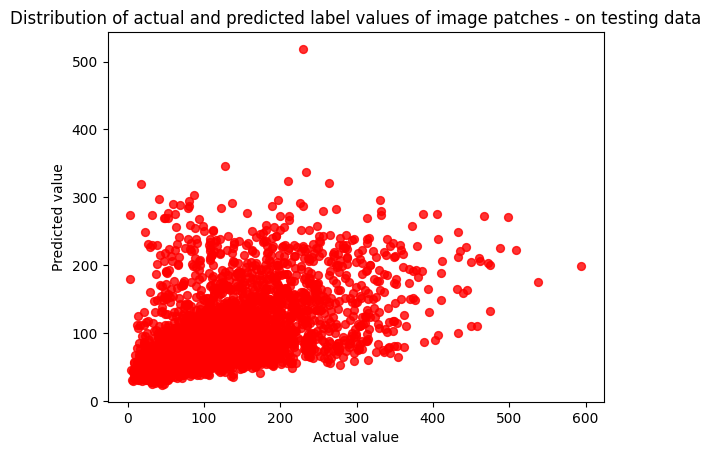

In [ ]:
dfPredicted_inverse.plot(kind='scatter',
                         title='Distribution of actual and predicted label values of image patches - on testing data',
                         x='label',
                         y='pred',
                         xlabel='Actual value',
                         ylabel='Predicted value',
                         s=32,
                         alpha=.8,
                         color='red')

Distribution of difference between actual and predicted values

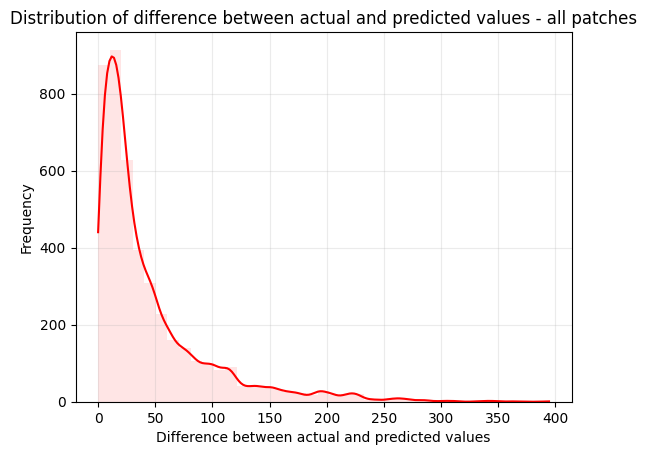

In [ ]:
import seaborn as sns

sns.histplot(data=dfPredicted_inverse, x='diff', binwidth=10, linewidth=0, color='red', alpha=0.1, kde=True, kde_kws={'bw_adjust': 0.5})

plt.title('Distribution of difference between actual and predicted values - all patches')
plt.xlabel('Difference between actual and predicted values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.25)
plt.show()

Boxplot of the same thing

<Axes: title={'center': 'Distribution of difference between actual and predicted values of labels'}, ylabel='Difference between actual and predicted'>

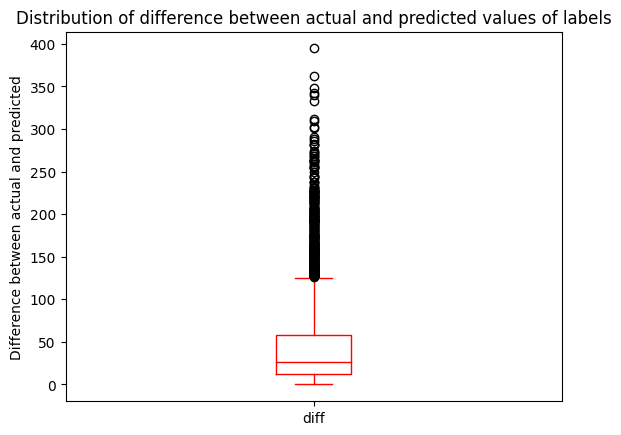

In [ ]:
dfPredicted_inverse['diff'].plot(kind='box',
                                 title='Distribution of difference between actual and predicted values of labels',
                                 ylabel='Difference between actual and predicted',
                                 color='red',)

Plot the distribution of diff and pred, and diff and label

<Axes: title={'center': 'Distribution between difference of actual and predicted label values and the predicted value'}, xlabel='Difference', ylabel='Predicted value'>

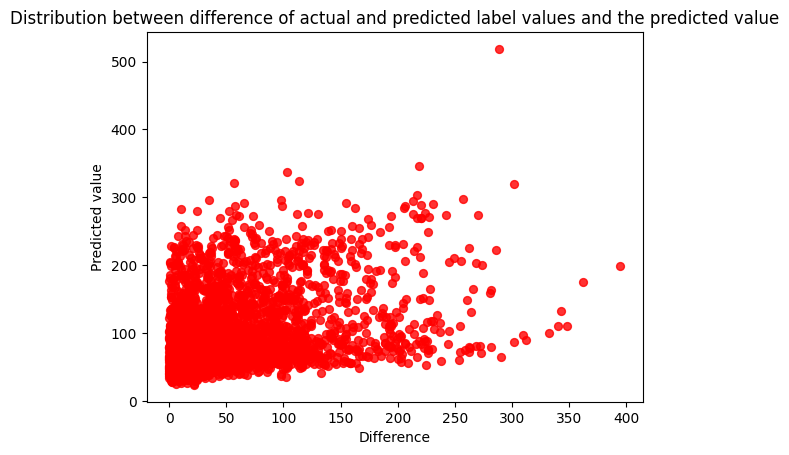

In [ ]:
# scatter graph of 2D distribution of diff and pred
dfPredicted_inverse.plot(kind='scatter',
                         title='Distribution between difference of actual and predicted label values and the predicted value',
                         x='diff',
                         y='pred',
                         xlabel='Difference',
                         ylabel='Predicted value',
                         s=32,
                         alpha=.8,
                         color='red')

<Axes: title={'center': 'Distribution between difference of actual and predicted label values and the actual value'}, xlabel='Difference', ylabel='Actual value'>

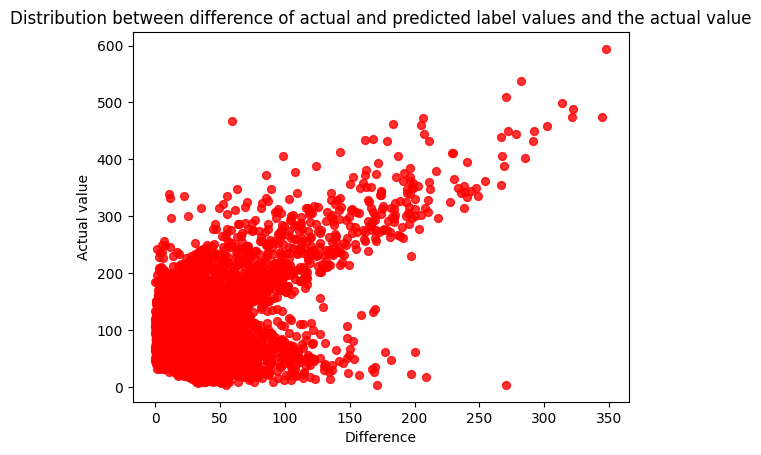

In [ ]:
# scatter graph of 2D distribution of diff and label
dfPredicted_inverse.plot(kind='scatter',
                         title='Distribution of difference between actual and predicted label values and the actual value',
                         x='diff',
                         y='label',
                         xlabel='Difference',
                         ylabel='Actual value',
                         s=32,
                         alpha=.8,
                         color='red')

Plotting a line of best fit on this

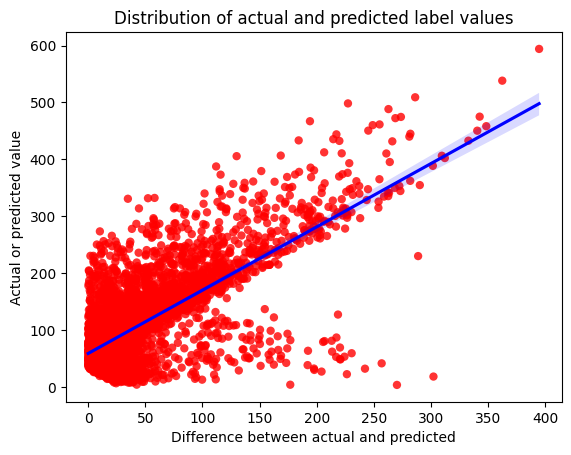

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=dfPredicted_inverse, x='diff', y='label', color='red', alpha=0.8, edgecolor='none')
sns.regplot(data=dfPredicted_inverse, x='diff', y='label', scatter=False, color='blue')
plt.title('Distribution of difference between actual and predicted label values and actual value')
plt.xlabel('Difference between actual and predicted')
plt.ylabel('Actual value')
plt.show()

Displays example patches of training dataset with labels

In [ ]:
# Compiles test data
exampleDatagen = ImageDataGenerator(
  rescale=1./255
)

exampleGen = exampleDatagen.flow_from_dataframe(
  dataframe=dfExample,
  directory=IMAGE_SOURCE,
  x_col="filename",
  y_col="label",
  class_mode="raw",
  batch_size=256,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
)

Found 23343 validated image filenames.


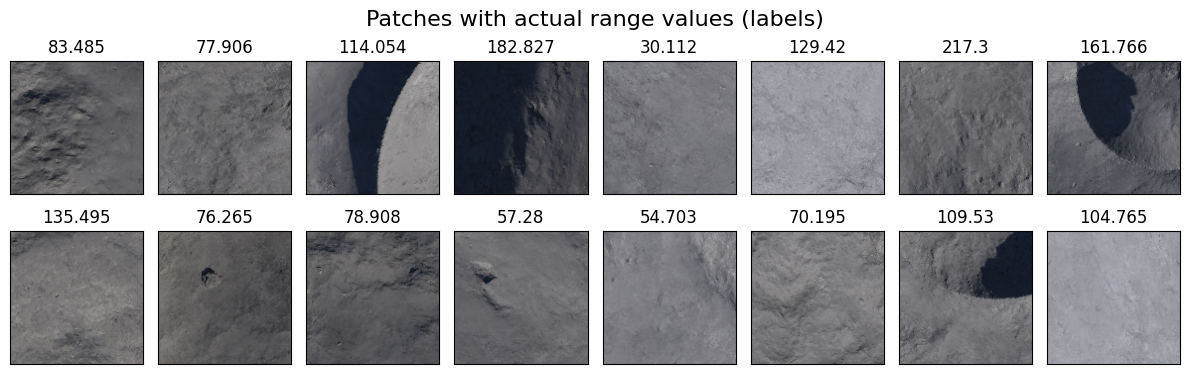

In [ ]:
features, target = next(exampleGen)

# Display 16 patches
fig = plt.figure(figsize=(12,8))
plt.suptitle('Patches with actual range values (labels)',  y=0.9,fontsize=16, color='black')

for i in range(16):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')

	  # Remove axes on each patch
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# Using the model to predict a single image

Creating a dataframe with this data in

In [ ]:
dfNames = pd.read_csv(CSV_SOURCE)

j = 437

if j > 390:
  dfNames = pd.read_csv(TEST_CSV_SOURCE)

dfPatch_original = dfNames[dfNames['filename'].str.match(rf'mars_image_c-{j}~\d+\.jpg')]

# Patches with no vertices dropped
dfPatch_original = dfPatch_original.drop(dfPatch_original[dfPatch_original["label"] == -20000.000].index)

dfPatch_original.sort_values('label')

,id,label,filename
2991,2991,25.893,mars_image_c-437~47.jpg
2949,2949,28.370,mars_image_c-437~5.jpg
2950,2950,29.212,mars_image_c-437~6.jpg
2948,2948,32.142,mars_image_c-437~4.jpg
3007,3007,34.333,mars_image_c-437~63.jpg
...,...,...,...
3001,3001,241.601,mars_image_c-437~57.jpg
2994,2994,274.319,mars_image_c-437~50.jpg
2961,2961,304.396,mars_image_c-437~17.jpg
2962,2962,312.935,mars_image_c-437~18.jpg


Predicting each patch - **Fixed**

In [ ]:
from scipy.special import inv_boxcox

patchDatagen = ImageDataGenerator(
  # Normalises rgb values to 0-1
  rescale=1./255
)

patchGen = patchDatagen.flow_from_dataframe(
  dataframe=dfPatch_original,
  directory=IMAGE_SOURCE,
  x_col="filename",
  y_col="label",
  batch_size=1,
  class_mode=None,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  shuffle=False,
  color_mode='grayscale'
)

patchGen.reset()
pred = model.predict(patchGen, steps=len(dfPatch_original))

dfPredictedPatch = pd.DataFrame({'id':dfPatch_original['id'],'label':dfPatch_original['label'],'filename':dfPatch_original['filename'],'pred':pred.flatten()})

predInverseScale = scaler.inverse_transform(dfPredictedPatch['pred'].values.reshape(-1,1))

predInverseTrans = inv_boxcox(predInverseScale.flatten(), lambda_)

dfPatch = dfPredictedPatch.copy()
dfPatch['pred'] = predInverseTrans

dfPatch.sort_values('pred')

Found 64 validated image filenames.
64/64 [==============================] - 0s 2ms/step


,id,label,filename,pred
2990,2990,75.565,mars_image_c-437~46.jpg,50.287060
2982,2982,127.845,mars_image_c-437~38.jpg,51.120201
2948,2948,32.142,mars_image_c-437~4.jpg,54.080734
2981,2981,91.990,mars_image_c-437~37.jpg,54.509117
2956,2956,45.490,mars_image_c-437~12.jpg,55.200157
...,...,...,...,...
2986,2986,199.101,mars_image_c-437~42.jpg,162.329361
2954,2954,233.876,mars_image_c-437~10.jpg,170.979218
2945,2945,209.212,mars_image_c-437~1.jpg,194.834259
2953,2953,316.981,mars_image_c-437~9.jpg,222.735291


Highlighting highest and lowest predicted

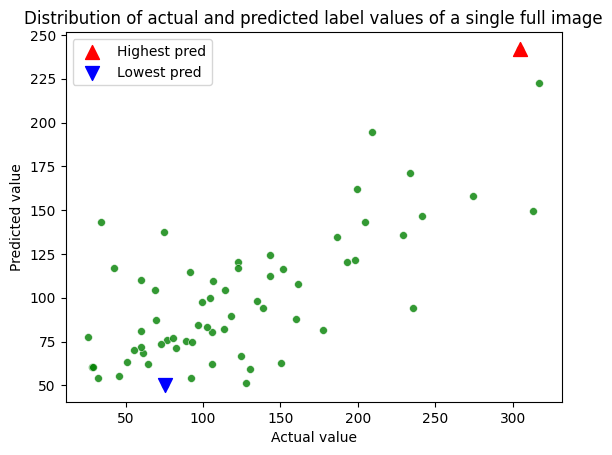

In [ ]:
import seaborn as sns

# Finds the id of the highest and lowest predicted patches
highestPred = dfPatch['pred'].idxmax()
lowestPred = dfPatch['pred'].idxmin()

# Create a scatter plot
sns.scatterplot(data=dfPatch,
                x='label',
                y='pred',
                s=32,
                alpha=.8,
                color='green')

# Highlight the highest and lowest points
plt.scatter(dfPatch.loc[highestPred, 'label'],
            dfPatch.loc[highestPred, 'pred'],
            color='red',
            s=100,
            marker='^',
            label='Highest pred')

plt.scatter(dfPatch.loc[lowestPred, 'label'],
            dfPatch.loc[lowestPred, 'pred'],
            color='blue',
            s=100,
            marker='v',
            label='Lowest pred')

# Set labels and title
plt.title('Distribution of actual and predicted label values of a single full image')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')

# Show legend
plt.legend()

# Show plot
plt.show()

Calculating percentile accuracy within patch

In [ ]:
dfPatchSorted = dfPatch.sort_values(by='label')
dfPatchSorted['rank_label'] = dfPatchSorted['label'].rank(method='dense').astype(int)

#dfPatchSorted.head(15)

In [ ]:
# Finds label value of the record with the lowest pred value
lowestPredLabel = dfPatchSorted.loc[dfPatchSorted['pred'].idxmin(), 'label']

# Find the rank position of the lowestPredLabel
lowestPredRankLabel = dfPatchSorted.loc[lowestPred, 'rank_label']

# Calculate percentile by dividing rank by total number of patches (64)
percentile = int(round((lowestPredRankLabel / 64) * 100, 0))

print(f"Percentile Accuracy of prediction: {percentile}-th %")

Percentile Accuracy of prediction: 30-th %


Plotting distribution between actual and predicted values within an image

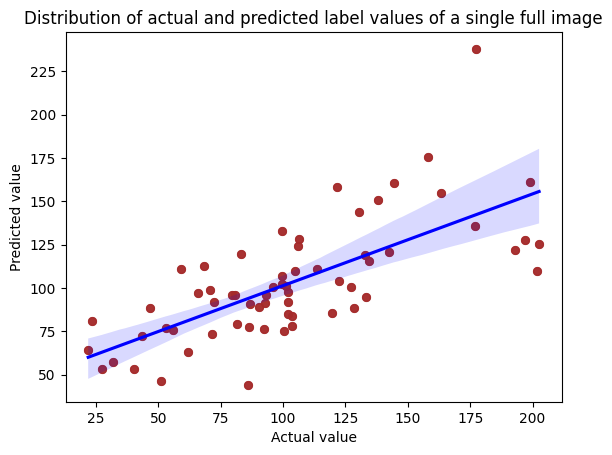

In [ ]:
dfPatch.plot(kind='scatter',
            title='Distribution of actual and predicted label values of a single full image',
            x='label',
            y='pred',
            xlabel='Actual value',
            ylabel='Predicted value',
            s=32,
            alpha=.8,
            color='brown')

sns.scatterplot(data=dfPatch, x='label', y='pred', color='brown', alpha=0.8, edgecolor=None)
sns.regplot(data=dfPatch, x='label', y='pred', scatter=False, color='blue')
plt.title('Distribution of actual and predicted label values of a single full image')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.show()

Calculating difference

In [ ]:
dfPatch['diff'] = np.abs(dfPatch['label'] - dfPatch['pred'])

Plotting the distribution of difference

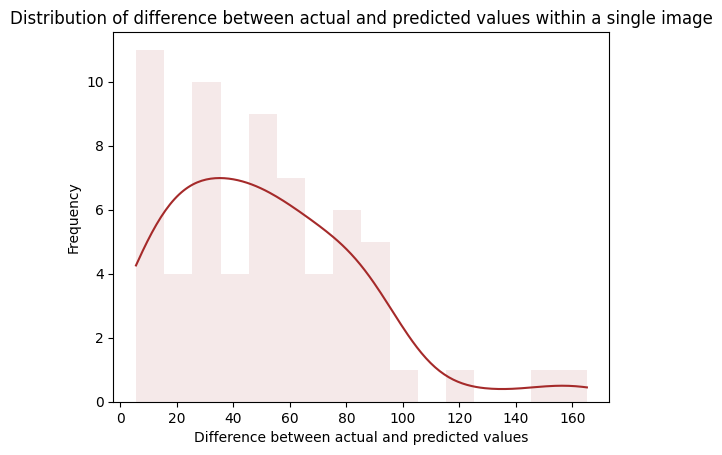

In [ ]:
sns.histplot(data=dfPatch, x='diff', binwidth=10, linewidth=0, color='brown', alpha=0.1, kde=True)

plt.title('Distribution of difference between actual and predicted values within a single image')
plt.xlabel('Difference between actual and predicted values')
plt.ylabel('Frequency')
plt.show()

Distribution of difference and actual values

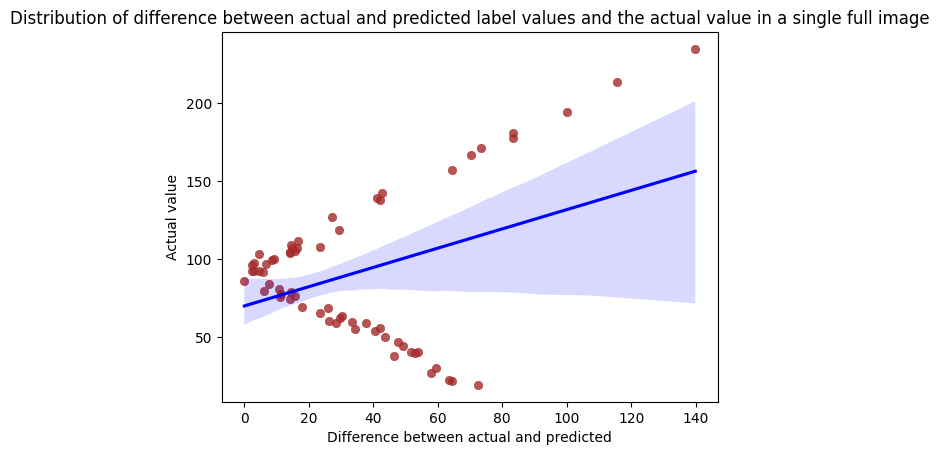

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=dfPatch, x='diff', y='label', color='brown', alpha=0.8, edgecolor=None)
sns.regplot(data=dfPatch, x='diff', y='label', scatter=False, color='blue')
plt.title('Distribution of difference between actual and predicted label values and the actual value in a single full image')
plt.xlabel('Difference between actual and predicted')
plt.ylabel('Actual value')
plt.show()

Distribution of label values of this image

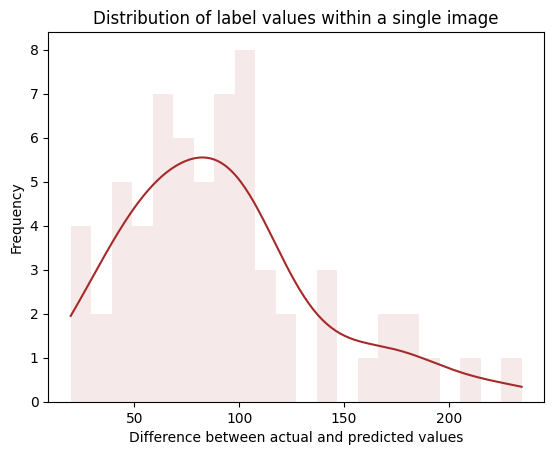

In [ ]:
sns.histplot(data=dfPatch, x='label', binwidth=10, linewidth=0, color='brown', alpha=0.1, kde=True)

plt.title('Distribution of label values within a single image')
plt.xlabel('Difference between actual and predicted values')
plt.ylabel('Frequency')
plt.show()

# Simulating using the model to predict smoothest patch in an image

In [ ]:
import cv2
import numpy as np

lowest = (100.000, -1)

# Image Number
j = 0

for i in range(64):
  predImageName = f"{j}~{i}"
  predImagePath = os.path.join(IMAGE_SOURCE, f"mars_image_c-{predImageName}.jpg")
  print(predImagePath)

  predImage = cv2.imread(predImagePath)

  prediction = model.predict(np.expand_dims(predImage, axis=0))
  pred = float(str(prediction).strip("[]"))

  if pred < lowest[0]:
    lowest = (pred, f"{j}~{i}")

print(f"Lowest: {lowest}")

Final_Rendering/images/mars_image_c-0~0.jpg
1/1 [==============================] - 0s 25ms/step
Final_Rendering/images/mars_image_c-0~1.jpg
1/1 [==============================] - 0s 20ms/step
Final_Rendering/images/mars_image_c-0~2.jpg
1/1 [==============================] - 0s 20ms/step
Final_Rendering/images/mars_image_c-0~3.jpg
1/1 [==============================] - 0s 20ms/step
Final_Rendering/images/mars_image_c-0~4.jpg
1/1 [==============================] - 0s 21ms/step
Final_Rendering/images/mars_image_c-0~5.jpg
1/1 [==============================] - 0s 20ms/step
Final_Rendering/images/mars_image_c-0~6.jpg
1/1 [==============================] - 0s 20ms/step
Final_Rendering/images/mars_image_c-0~7.jpg
1/1 [==============================] - 0s 19ms/step
Final_Rendering/images/mars_image_c-0~8.jpg
1/1 [==============================] - 0s 20ms/step
Final_Rendering/images/mars_image_c-0~9.jpg
1/1 [==============================] - 0s 21ms/step
Final_Rendering/images/mars_image_c-0~10